In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, label_binarize

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

import pickle

# Setup

## Cek Missing Value

In [2]:
# Cek Missing Value
def cek_missing(df):
    return pd.DataFrame({"Jumlah": df.isna().sum(), "Persentase": df.isna().mean() * 100})

## Drop Columns

In [3]:
# Drop Columns
class ColumnDropper(BaseEstimator, TransformerMixin):

    def __init__(self, to_drop):
        self.to_drop = to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.to_drop = [col for col in self.to_drop if col in X.columns]
        return X.drop(columns=self.to_drop)

## One-Hot Encoding

In [4]:
# One-Hot Encoding
class OneHotFeatureEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, to_encode):
        self.to_encode = to_encode
        self.encoder = OneHotEncoder(
            drop='first',
            sparse_output=False,
            dtype=np.int8,
            handle_unknown='ignore',
            feature_name_combiner='concat'
        )

    def fit(self, X, y=None):
        self.encoder.fit(X[self.to_encode])
        return self

    def transform(self, X):
        X_one_hot = self.encoder.transform(X[self.to_encode])
        one_hot_df = pd.DataFrame(
            X_one_hot,
            columns=self.encoder.get_feature_names_out(self.to_encode)
        )
        X_reset = X.reset_index(drop=True)

        return pd.concat([X_reset.drop(columns=self.to_encode), one_hot_df], axis=1)

# Read Dataset

In [5]:
train = pd.read_csv("../datasets/KDDTrain+.csv")
test = pd.read_csv("../datasets/KDDTest+.csv")
df = pd.concat([train, test], axis=0)

# Rename column
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label', 'difficulty'
]
df.rename({f"Column{i+1}" : col for i,col in enumerate(columns)}, axis=1, inplace=True)

# Mapping tipe serangan ke kategori
attack_mapping = {
    # Normal
    'normal': 'normal',

    # DoS (Denial of Service)
    'neptune': 'DoS',
    'back': 'DoS',
    'teardrop': 'DoS',
    'smurf': 'DoS',
    'pod': 'DoS',
    'land': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'mailbomb': 'DoS',
    'udpstorm': 'DoS',
    'ps': 'DoS',
    'xlock': 'DoS',

    # R2L (Remote to Local)
    'guess_passwd': 'R2L',
    'ftp_write': 'R2L',
    'imap': 'R2L',
    'phf': 'R2L',
    'multihop': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'spy': 'R2L',
    'snmpguess': 'R2L',
    'snmpgetattack': 'R2L',
    'sendmail': 'R2L',
    'xsnoop': 'R2L',
    'sqlattack': 'R2L',

    # U2R (User to Root)
    'buffer_overflow': 'U2R',
    'rootkit': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'xterm': 'U2R',
    'named': 'U2R',
    'worm': 'U2R',

    # Probing (Surveillance & Scanning)
    'ipsweep': 'Probing',
    'portsweep': 'Probing',
    'nmap': 'Probing',
    'satan': 'Probing',
    'mscan': 'Probing',
    'saint': 'Probing',
    'httptunnel': 'Probing',
}
df['label'] = df['label'].map(attack_mapping)

print(df.shape)
df.head()

(148517, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


# Quick EDA

## 1. Drop Duplicated

In [6]:
df.drop(columns=['difficulty']).duplicated().sum()

np.int64(629)

In [7]:
df.drop_duplicates(subset=[col for col in df.columns if col != 'difficulty'], keep='first', inplace=True)
df.shape

(147888, 43)

## 2. Cek Missing Value

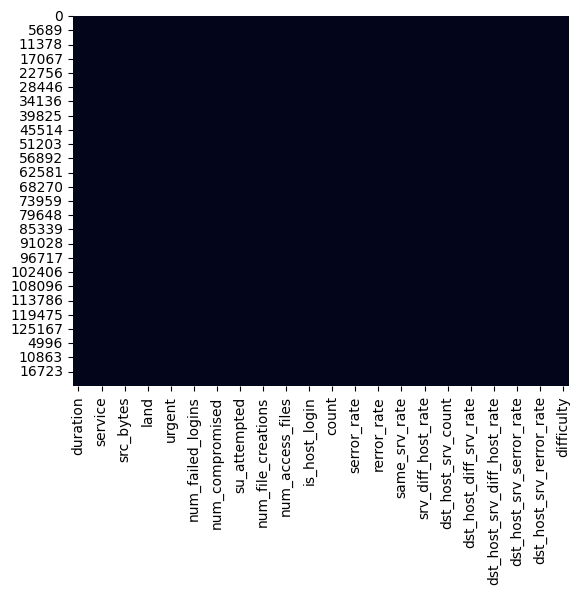

In [8]:
sns.heatmap(df.isnull(), cbar=False);

In [9]:
cek_missing(df)

,Jumlah,Persentase
duration,0,0.0
protocol_type,0,0.0
service,0,0.0
flag,0,0.0
src_bytes,0,0.0
dst_bytes,0,0.0
land,0,0.0
wrong_fragment,0,0.0
urgent,0,0.0
hot,0,0.0


## 3. Cek Imbalance Dataset

In [10]:
print("Target proportion:")
df.label.value_counts(normalize=False)

Target proportion:


label
normal     76967
DoS        53009
Probing    14068
R2L         3723
U2R          121
Name: count, dtype: int64

# Splitting Dataset

In [11]:
X = df.drop(columns=["label"])
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((118310, 42), (29578, 42), (118310,), (29578,))

# Feature Engineering & Data Preprocessing

In [12]:
one_hot_encoding_features = ['protocol_type', 'service', 'flag']
to_drop_features = ['difficulty']

In [13]:
preprocessor = Pipeline(steps=[
    ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
    ('col_dropper', ColumnDropper(to_drop=to_drop_features))
])

In [14]:
X_train_prepared = preprocessor.fit_transform(X_train, y_train)
print("Shape of X_train_prepared:", X_train_prepared.shape)

Shape of X_train_prepared: (118310, 119)


# Model Training

## 1. Decision Tree

In [15]:
# Train model Decision Tree
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_prepared, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

C:\Users\Tsaqif\miniconda3\envs\env_sml\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10602
     Probing       0.99      0.99      0.99      2814
         R2L       0.94      0.93      0.94       745
         U2R       0.48      0.42      0.44        24
      normal       0.99      0.99      0.99     15393

    accuracy                           0.99     29578
   macro avg       0.88      0.87      0.87     29578
weighted avg       0.99      0.99      0.99     29578



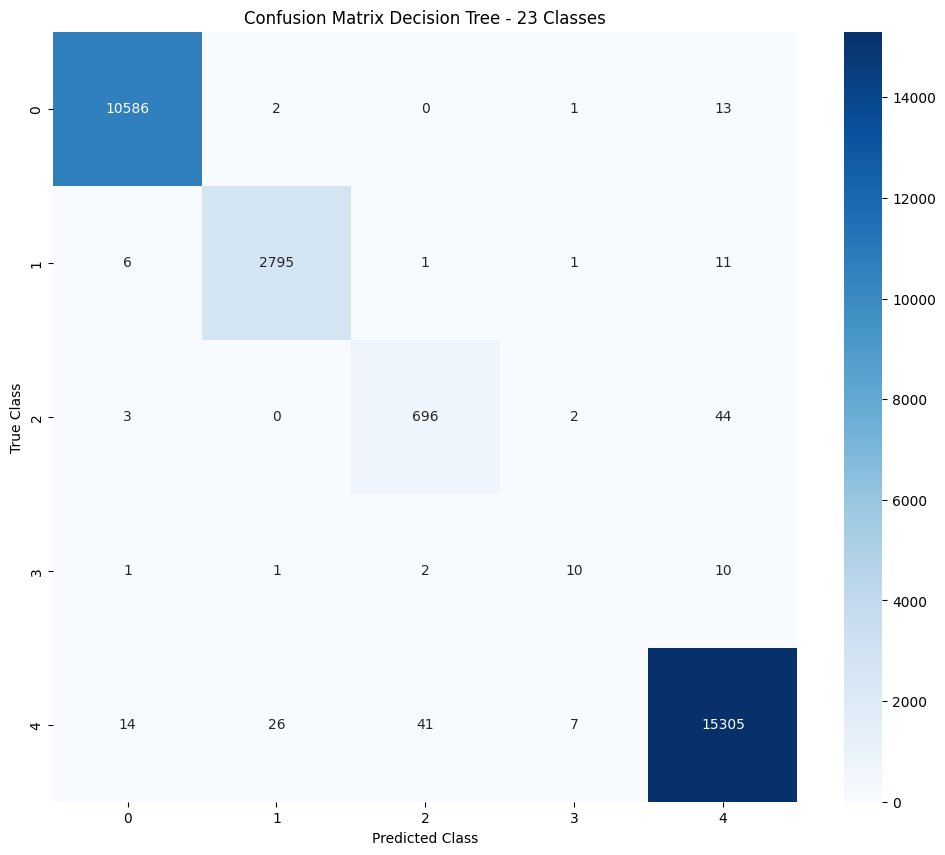

In [16]:
# Transform test set (menggunakan transform saja, bukan fit_transform!)
X_test_prepared = preprocessor.transform(X_test)

# Predict test set
y_pred = clf.predict(X_test_prepared)

# Evaluasi
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix Decision Tree - 23 Classes')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

C:\Users\Tsaqif\AppData\Local\Temp\ipykernel_24984\1140415453.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(classes))  # Untuk banyak class


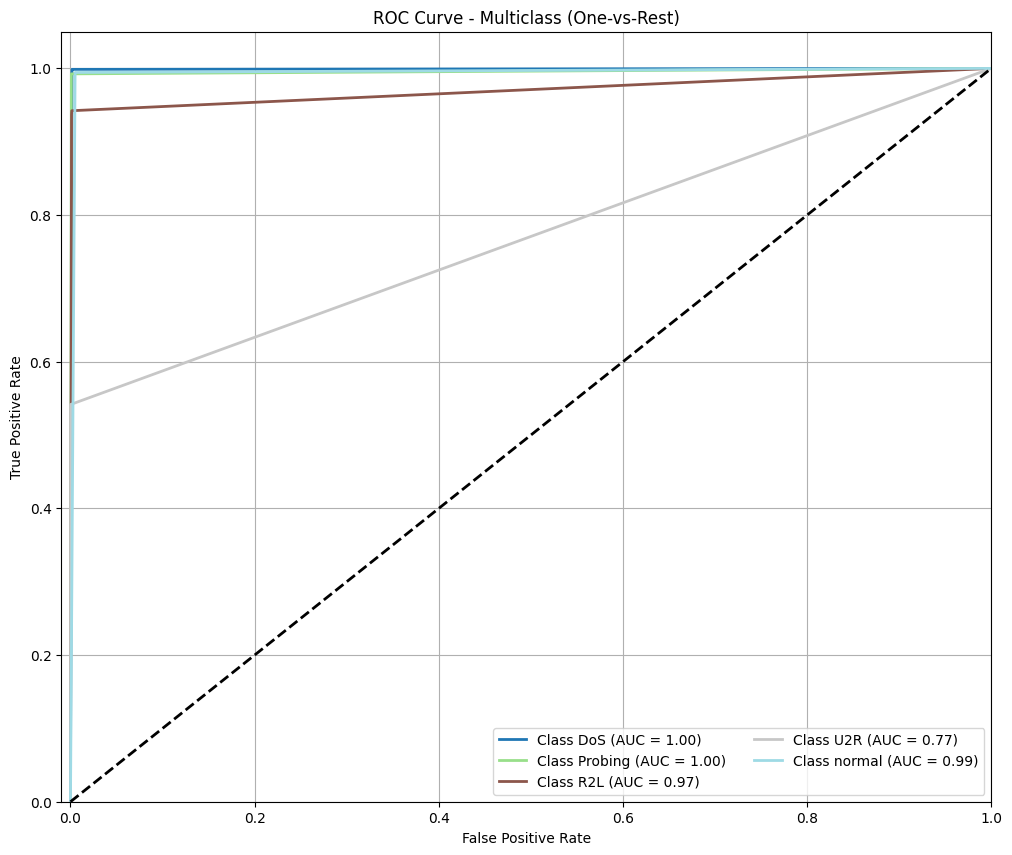

In [17]:
# Binarize the output for multiclass ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Jika model bukan OvR secara default (DecisionTreeClassifier bukan), maka wrap dengan OneVsRestClassifier
clf_ovr = OneVsRestClassifier(clf)
clf_ovr.fit(X_train_prepared, label_binarize(y_train, classes=classes))
y_score = clf_ovr.predict_proba(X_test_prepared)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap('tab20', len(classes))  # Untuk banyak class

for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass (One-vs-Rest)')
plt.legend(loc='lower right', ncol=2)
plt.grid(True)
plt.show()

In [18]:
with open('../models/dt_model_pipeline.pkl', 'wb') as file:
    pickle.dump({
        'model_dt': clf,
        'preprocessor_dt': preprocessor,
    }, file)

## 2. XGBoost

In [19]:
# Encode label menjadi angka
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [20]:
# Multiclass XGBoost
xgb_clf = XGBClassifier(
    objective='multi:softprob',  # karena kita ingin probabilitas untuk ROC
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=42
)

# Wrap dengan OneVsRest untuk ROC multiclass
ovr_clf = OneVsRestClassifier(xgb_clf)

# Binarize target
y_train_bin = label_binarize(y_train_enc, classes=np.arange(len(label_encoder.classes_)))
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(label_encoder.classes_)))

# Fit OvR classifier
ovr_clf.fit(X_train_prepared, y_train_bin)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_class=5, ...))

In [21]:
# Predict
y_pred = ovr_clf.predict(X_test_prepared)
y_pred_labels = np.argmax(y_pred, axis=1)

Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10602
     Probing       1.00      1.00      1.00      2814
         R2L       0.98      0.95      0.97       745
         U2R       0.75      0.50      0.60        24
      normal       1.00      1.00      1.00     15393

    accuracy                           1.00     29578
   macro avg       0.94      0.89      0.91     29578
weighted avg       1.00      1.00      1.00     29578



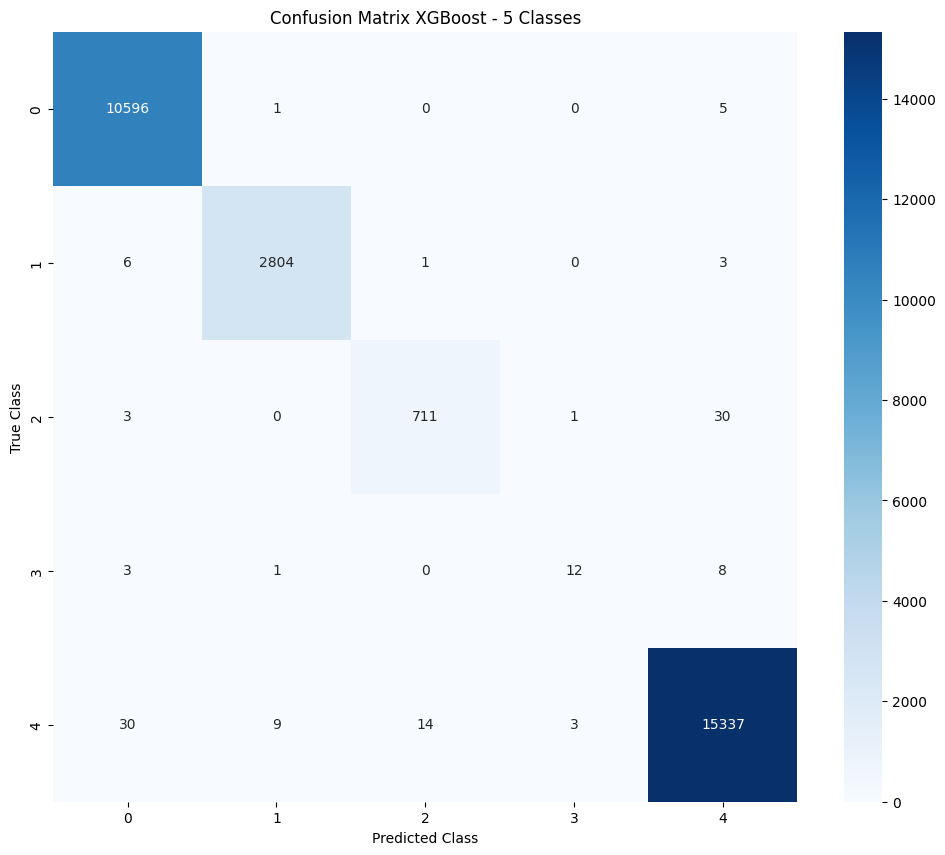

In [22]:
print("Classification Report:\n", classification_report(
    y_test_enc,
    y_pred_labels,
    target_names=label_encoder.classes_
))
cm = confusion_matrix(y_test_enc, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix XGBoost - 5 Classes')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

C:\Users\Tsaqif\AppData\Local\Temp\ipykernel_24984\3533216183.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(classes))


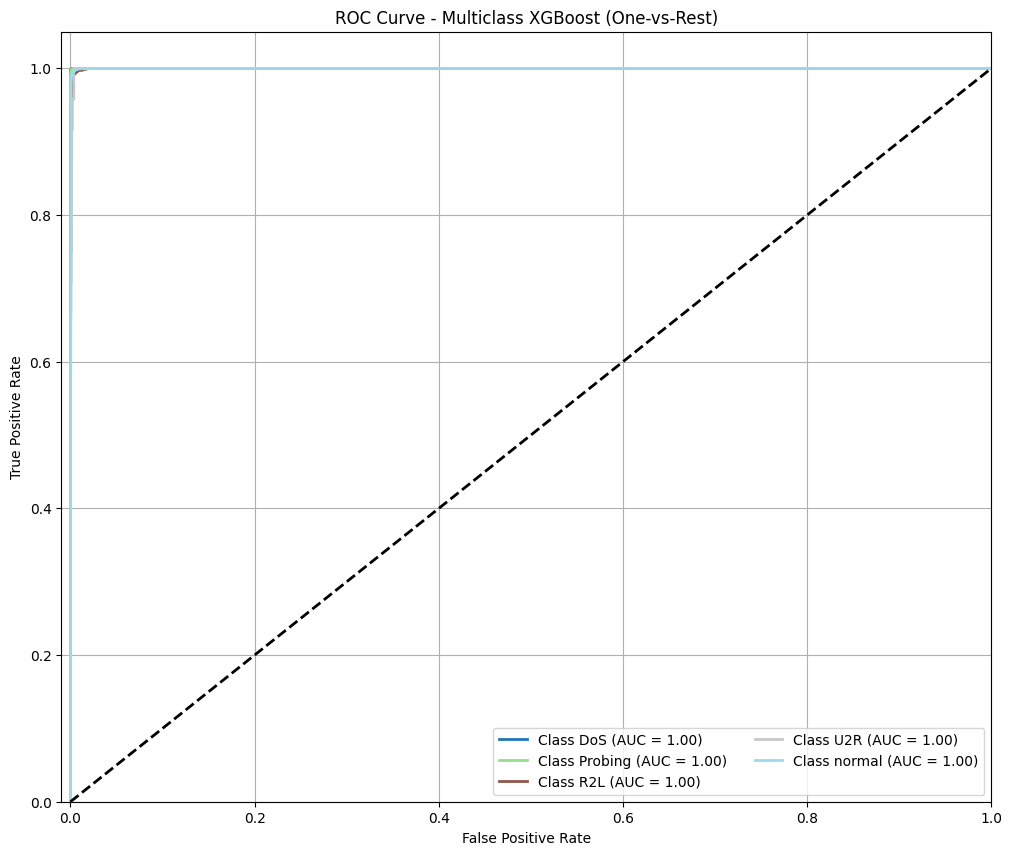

In [23]:
# Get probability estimates
y_score = ovr_clf.predict_proba(X_test_prepared)

# ROC computation
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = np.unique(y_test)

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap('tab20', len(classes))

for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass XGBoost (One-vs-Rest)')
plt.legend(loc='lower right', ncol=2)
plt.grid(True)
plt.show()

In [24]:
with open('../models/xgb_model_pipeline.pkl', 'wb') as file:
    pickle.dump({
        'model_xgboost_ovr': ovr_clf,
        'preprocessor_xgboost_ovr': preprocessor,
        'label_encoder_xgboost_ovr': label_encoder
    }, file)